Load audio files and process them by resampling to a target sampling rate and adjusting their length to match a specified duration - truncate longer ones, pad the shorter ones

In [2]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

def load_audio(file_path, target_sr = 16000):
    audio = tf.io.read_file(file_path)
    audio, sr = tf.audio.decode_wav(audio)

    if sr != target_sr:
        audio = tfio.audio.resample(audio, rate_in = sr, rate_out = target_sr)
    return tf.squeeze(audio, axis = -1), target_sr

waveform_to_spectrogram converts audio waveform into a spectrogram using STFT and outputs a magnitude spectrogram with a channel dimension. resize_spectrogram resizes the spectrogram to a target shape and adds a batch dimension for model compatibility.

In [3]:
def waveform_to_spectrogram(audio_waveform, frame_length=256, frame_step=128, fft_length=256):
    spectrogram = tf.signal.stft(audio_waveform, 
                                  frame_length=frame_length, 
                                  frame_step=frame_step, 
                                  fft_length=fft_length)
    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram

def resize_spectrogram(spectrogram, target_shape=(124, 129)):
    spectrogram_resized = tf.image.resize(spectrogram, target_shape)
    spectrogram_resized = tf.expand_dims(spectrogram_resized, axis = 0)
    return spectrogram_resized

Generates adversarial audio by computing gradients of the loss with respect to the input audio, perturbing it with a scaled signed gradient to mislead the model.

In [55]:
def generate_adversial_audio(model, audio, label, epsilon = 0.2, entropy_weight = 0.05):
    
    
    with tf.GradientTape() as tape:
        tape.watch(audio)
        prediction = model(audio)
        prediction = tf.nn.softmax(prediction, axis=-1)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
        entropy_loss = -tf.reduce_sum(prediction * tf.math.log(prediction + 1e-5), axis=-1)
        total_loss = loss + entropy_weight * entropy_loss


    gradient = tape.gradient(total_loss, audio)
    signed_grad = tf.sign(gradient)
    adversarial_audio = audio + epsilon * signed_grad

    return adversarial_audio


get_model_prediction converts the model's output into probabilities, identifies the label with the highest probability, and returns the corresponding human-readable label and its probability.

In [5]:
def get_model_prediction(model, spectrogram, class_names):
    logits = model(spectrogram)
    
    probabilities = tf.nn.softmax(logits)
    predicted_index = tf.argmax(probabilities, axis=-1).numpy()[0]
    
    predicted_label = class_names[predicted_index]
    
    predicted_prob = probabilities[0, predicted_index].numpy()
    
    return predicted_label, predicted_prob

This code loads a sample audio file (saying 'no') with a corresponding label 0 from the predefined class_names list. It transforms the sound for compatibility with a pre-trained model (model0.h5). An adversarial version of the audio is generated using the function generate_adversarial_audio. Predictions and confidence scores are obtained for both the original and perturbed spectrograms using get_model_prediction(). Finally, the original and adversarial spectrograms are plotted side by side to visualize the seamless transition.

(124, 129, 1)
Predicted Label(Original): off, Confidence: 0.9999992847442627
Predicted Label(Perturbated): unknown, Confidence: 0.999998927116394


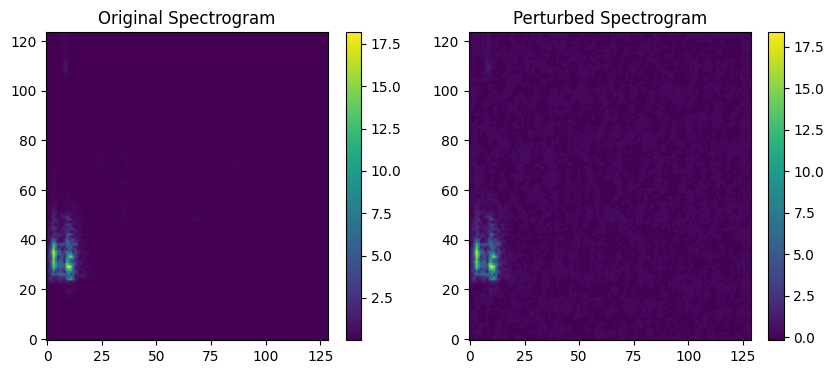

In [56]:
class_names = ['yes','no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown']

model = tf.keras.models.load_model('dp_complex_0_3_lr_0_001_af_leaky_relu_Adam_epochs_10_noise_set.h5')

audio, sr = load_audio('./test/audio/clip_0d3d21b84.wav')

label = tf.constant([7])

spectrogram = waveform_to_spectrogram(audio)
print(spectrogram.shape)
spectrogram_resized = resize_spectrogram(spectrogram)

adversarial_audio = generate_adversial_audio(model, spectrogram_resized, label)

predicted_label, predicted_prob = get_model_prediction(model, spectrogram_resized, class_names)

print(f"Predicted Label(Original): {predicted_label}, Confidence: {predicted_prob}")

predicted_label, predicted_prob = get_model_prediction(model, adversarial_audio, class_names)

print(f"Predicted Label(Perturbated): {predicted_label}, Confidence: {predicted_prob}")


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(spectrogram).numpy(), aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(adversarial_audio).numpy(), aspect='auto', origin='lower')
plt.title('Perturbed Spectrogram')
plt.colorbar()

plt.show()

To demonstrate the seamless transition between perturbed and original sound, we used the spectrogram_to_audio function to reconstruct the audio. First, we compute the phase using tf.math.angle(), then calculate the real and imaginary parts using the formulas:
- Imaginary part: |value| * sin(phase)
- Real part: |value| * cos(phase)
After reconstructing the complex spectrogram, we use inverse STFT to restore the waveform and save the audio for comparison.

In [54]:
import numpy as np
import tensorflow as tf
import librosa
import soundfile as sf
import IPython.display as ipd

def spectrogram_to_audio(tensor_spectrogram, sr=16000, frame_length=256, frame_step=128, fft_length=256):
    tensor_spectrogram = tf.squeeze(tensor_spectrogram)
    
    tensor_spectrogram = tf.math.abs(tensor_spectrogram)
    phase = tf.math.angle(tensor_spectrogram)
    real_part = tensor_spectrogram * tf.cos(phase)
    imag_part = tensor_spectrogram * tf.sin(phase)
    complex_spectrogram = tf.complex(real_part, imag_part)

    waveform = tf.signal.inverse_stft(
        complex_spectrogram,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length,
        window_fn=tf.signal.hann_window
    )
    # In case you don't hear the sound uncomment the line, to amplify the sound
    waveform = waveform / tf.reduce_max(tf.abs(waveform))
    return waveform




sr = 16000

audio_waveform = spectrogram_to_audio(adversarial_audio, sr=sr)
sf.write("reconstructed_audio.wav", audio_waveform, sr)
print("Audio saved as reconstructed_audio.wav")

ipd.display(ipd.Audio('./test/audio/clip_0d3d21b84.wav'))
ipd.display(ipd.Audio('reconstructed_audio.wav'))

Audio saved as reconstructed_audio.wav
